[View in Colaboratory](https://colab.research.google.com/github/kashefy/batch_size/blob/master/batch_size.ipynb)

In [1]:
import os
is_env_collab = os.environ['HOME'] == '/content'
if is_env_collab:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
    !apt-get update -qq 2>&1 > /dev/null
    !apt-get -y install -qq google-drive-ocamlfuse fuse
    from google.colab import auth
    auth.authenticate_user()
    from oauth2client.client import GoogleCredentials
    creds = GoogleCredentials.get_application_default()
    import getpass
    !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
    vcode = getpass.getpass()
    !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
    !mkdir -p drive
    !google-drive-ocamlfuse drive
    !rm -rf `pwd`/nideep
    !git clone --branch=layerwise_new --depth=1 https://github.com/kashefy/nideep.git `pwd`/nideep
    !export PYTHONPATH=`pwd`/nideep:$PYTHONPATH
    # !export PYTHONPATH=`pwd`/nideep/nideep:$PYTHONPATH
    import sys
    sys.path.append('./nideep')

gpg: keybox '/tmp/tmpyt0ip5w8/pubring.gpg' created
gpg: /tmp/tmpyt0ip5w8/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
Cloning into '/content/nideep'...
remote: Counting objects: 122, done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 122 (delta 4), reused 38 (delta 4), pack-reused 0
Receiving objects: 100% (122/122), 335.36 KiB | 5.08 MiB/s, done.
Resolving deltas: 100% (4/4), done.


# Imports amd definitions

In [2]:
import os
import collections
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print('Running Tensorflow in %s mode' % ['CPU', 'GPU'][tf.test.is_gpu_available()])
print(tf.test.gpu_device_name())
from tensorflow.contrib.learn.python.learn.datasets.mnist import dense_to_one_hot
from nideep.datasets.mnist.mnist_tf import MNIST
from nideep.eval.metric_tf import resettable_metric

Running Tensorflow in CPU mode



In [0]:
MetricOps = collections.namedtuple('MetricOps', ['metric', 'update', 'reset'])
    
class NetWrapper:
    def set(self, weights, biases, layers, logits, probs):
        self.weights = weights
        self.biases = biases
        self.layers = layers
        self.logits = logits
        self.probs = probs
        
    def __init__(self):
        self.weights = None
        self.biases = None
        self.layers = None
        self.logits = None
        self.probs = None

def _init_data_mnist(data_dir,
                     one_hot=True,
                     validation_size=5000,
                     data_seed=None):
    data = MNIST.read_data_sets(data_dir,
                                one_hot=one_hot,
                                validation_size=validation_size,
                                seed=data_seed)
    return data

def _init_acc_ops(y, y_true):
    y_class_op = tf.argmax(y_true, 1)
    predicted_class_op = tf.argmax(y, 1)
    metric_op, up_op, reset_op = resettable_metric(\
                                            tf.metrics.accuracy,
                                            'validation',
                                            labels=y_class_op,
                                            predictions=predicted_class_op)
    return MetricOps(metric=metric_op, update=up_op, reset=reset_op)

def net(x, dim_in, dims, dim_out):
    weights = {}
    biases = {}
    layers = {}
    dims = list(dims)
    dims.append(dim_out)
    in_op = x
    for idx, dim_cur in enumerate(dims):
        name_w = 'W-%d' % idx
        w = tf.get_variable(name_w, shape=[dim_in, dim_cur],
                            initializer=tf.random_normal_initializer(stddev=0.1))
        weights[name_w] = w
        name_b = 'b-%d' % idx
        b = tf.get_variable(name_b, shape=[dim_cur],
                            initializer=tf.constant_initializer(0.1))
        biases[name_b] = b
        name_fc = 'fc-%d' % idx
        fc = tf.add(tf.matmul(in_op, w), b, name=name_fc)
        layers[name_fc] = fc
        if idx < len(dims)-1:
            name_a = 'a-%d' % idx
            a = tf.sigmoid(fc, name=name_a)
            layers[name_a] = a
            in_op = a
        else:
            logits = fc
            probs = tf.nn.softmax(logits, name='probs')
        dim_in = dim_cur
    net = NetWrapper()
    net.set(weights, biases, layers, logits, probs)
    return net

def step(sess, x, y_true_recognition, batch_size_train, data, ops):
    batch_x, batch_y = data.train.next_batch(batch_size_train,
                                               shuffle=True)
    fd = {x  : batch_x,
          y_true_recognition : batch_y
         }
    return sess.run(ops, feed_dict=fd)

def validate(sess, x, y_true_recognition, batch_size_val, data, ops):
    num_batches_val = int(data.validation.num_examples/batch_size_val)
    for itr_val in range(num_batches_val):
        batch_x, batch_y = data.validation.next_batch(batch_size_val,
                                                              shuffle=False)
        fd = {x  : batch_x,
              y_true_recognition : batch_y
             }
        sess.run(ops, feed_dict=fd)
    pass 
    
def run(params):
    data = _init_data_mnist("MNIST_data/",
                            one_hot=True,
                            data_seed=params['data_seed'],
                            validation_size=params['validation_size'])
    num_epochs = params['num_epochs_max']
    batch_size_train = params['batch_size_train']
    batch_size_val = params['batch_size_val']
    num_batches_train = int(data.train.num_examples/batch_size_train)
    num_pixels = data.train.images[0].size
    num_classes =  data.train.labels[0].size
    lr_base = params['lr_base']
    num_hidden_per_layer = params['num_hidden_per_layer']
    with tf.Graph().as_default() as grph:
        
        x = tf.placeholder(tf.float32, [None, num_pixels])
        with tf.variable_scope("t0", reuse=None):
            net_t0 =\
                net(x,
                    num_pixels,
                    num_hidden_per_layer,
                    num_classes)
        y_true_recognition = tf.placeholder(tf.float32, [None, num_classes])
        cost_op = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits_v2(\
                            labels=y_true_recognition, logits=net_t0.logits))
        min_step = tf.train.GradientDescentOptimizer(lr_base).minimize(cost_op)
        init_ops = tf.global_variables_initializer()
        validation_ops =  _init_acc_ops(net_t0.probs, y_true_recognition)
        perf_val_acc = []
        perf_train_cost = []    
        with tf.Session(graph=grph) as sess:
            sess.run(init_ops)
            # train network
            for itr_epoch in range(num_epochs):
                for itr_train in range(10):#range(num_batches_train):
                    _, cost_train_out = step(sess, 
                                             x, y_true_recognition, 
                                             batch_size_train,
                                             data,
                                             [min_step, cost_op])
                    perf_train_cost.append((itr_epoch, itr_train, cost_train_out))
                # validation at the end of an epoch
                sess.run(validation_ops.reset)
                perf_epoch = validate(sess, 
                                      x, y_true_recognition, 
                                      batch_size_val,
                                      data,
                                     [validation_ops.metric,
                                      validation_ops.update])
                perf_val_acc.append(sess.run(validation_ops.metric))
    return np.array(perf_train_cost), np.array(perf_val_acc)



```
# Handle
```



In [0]:
import hashlib
import base64

def hash_str(s):
    u = base64.urlsafe_b64encode(hashlib.md5(s).digest())
    p = "".join([c for c in u if c.isalnum()]).rstrip() # maybe not safest but ok
    return p

def comb_to_str(comb):
    return '_'.join(['-'.join([k, str(v)]) for k, v in zip(params_pool.keys(), c)])

def get_combinations(list_params):
    mesh = np.meshgrid(*list_params, indexing = 'ij')

    list_mesh = []
    for m in mesh: list_mesh.append(m.flatten())
    return zip(*list_mesh), mesh

class ModeLR(Enum):
    LR_CONST = 1
class ModeBatchSize(Enum):
    BATCHSZ_CONST = 1
class ModeStop(Enum):
    STOP_MAX = 1
    
def list2csv(l):
    return str(l).replace('[', '').replace(']', '').replace(' ', '')

def csv2list(s, dtype):
    return [dtype(x) for x in s.split(',')]

def arrToDf(y, prefix=''):
    dfy = pd.DataFrame.from_records(y.tolist(), columns=y.dtype.names)
    dfy.columns = ['_'.join([prefix, str(int(c)+1)]) for c in dfy.columns]
    return(dfy)

def assignAllCols(src, dst):
    for c in src.columns:
        dst = dst.assign(new_col=src[c])
        dst = dst.rename(columns={"new_col": c})
    return dst

def load_df_from_path(fpath):
    if os.path.isfile(fpath):
        df = pd.read_pickle(fpath)
        print('Resuming from %d runs' % len(df))
    else:
        print('Starting from scratch')
        df = pd.DataFrame()
    return df

# Execute

In [6]:
params_pool = {
    'validation_size' : [1000, 2000, 4000, 5000, 10000, 20000],
    'lr_mode' : [ModeLR.LR_CONST],
    'lr_base' : [0.5, 0.1, 0.01],
    'batch_size_mode' : [ModeBatchSize.BATCHSZ_CONST],
    'batch_size_train' : [1, 2, 4, 16, 32, 64, 128, 2048],
    'batch_size_val' : [64],
    'stop_mode' : [ModeStop.STOP_MAX],
    'num_epochs_max' : [75],
    'num_hidden_per_layer' : [list2csv(x) for x in [[512, 256],
                                                    [64, 32]]],
    'data_seed'   : range(10),
}

print(params_pool.keys())
combs, _ = get_combinations(params_pool.values())
print(combs)
# print(combs)

['validation_size', 'num_hidden_per_layer', 'batch_size_val', 'lr_mode', 'data_seed', 'lr_base', 'batch_size_train', 'num_epochs_max', 'batch_size_mode', 'stop_mode']
[(1000, '512,256', 64, <ModeLR.LR_CONST: 1>, 0, 0.5, 1, 75, <ModeBatchSize.BATCHSZ_CONST: 1>, <ModeStop.STOP_MAX: 1>), (1000, '512,256', 64, <ModeLR.LR_CONST: 1>, 0, 0.5, 2, 75, <ModeBatchSize.BATCHSZ_CONST: 1>, <ModeStop.STOP_MAX: 1>), (1000, '512,256', 64, <ModeLR.LR_CONST: 1>, 0, 0.5, 4, 75, <ModeBatchSize.BATCHSZ_CONST: 1>, <ModeStop.STOP_MAX: 1>), (1000, '512,256', 64, <ModeLR.LR_CONST: 1>, 0, 0.5, 16, 75, <ModeBatchSize.BATCHSZ_CONST: 1>, <ModeStop.STOP_MAX: 1>), (1000, '512,256', 64, <ModeLR.LR_CONST: 1>, 0, 0.5, 32, 75, <ModeBatchSize.BATCHSZ_CONST: 1>, <ModeStop.STOP_MAX: 1>), (1000, '512,256', 64, <ModeLR.LR_CONST: 1>, 0, 0.5, 64, 75, <ModeBatchSize.BATCHSZ_CONST: 1>, <ModeStop.STOP_MAX: 1>), (1000, '512,256', 64, <ModeLR.LR_CONST: 1>, 0, 0.5, 128, 75, <ModeBatchSize.BATCHSZ_CONST: 1>, <ModeStop.STOP_MAX: 1>), (

In [0]:
# # Disable
# def blockPrint():
#     sys.stdout = open(os.devnull, 'w')

# # Restore
# def enablePrint():
#     sys.stdout = sys.__stdout__


#         enablePrint()
import pandas as pd
dir_ = 'drive/batch_size/180628/'
fpath_results = os.path.join(dir_, 'results.pkl')
            

results = load_df_from_path(fpath_results)
print(results)
max_runs = 10
for c in combs:
    hsh = hash_str(comb_to_str(c))
    params = {key: value for (key, value) in zip(params_pool.keys(), c)}
    for k in ['num_hidden_per_layer']:
        params[k] = csv2list(params[k], int)
    
    fpath_perf = os.path.join(dir_, '%s.npz' % hsh)
    if os.path.isfile(fpath_perf):
        print('Loading %s' % fpath_perf)
        f = np.load(fpath_perf)
        perf_train_cost_all = f['perf_train_cost_all'].tolist()
        perf_val_all = f['perf_val_all'].tolist()
        perf = dict(f)
        print('Resuming %s from combination %s from %s runs' % (perf.keys(), hsh, len(perf_train_cost_all),))
        f.close()
    else:        
        print('Starting %s from scratch' % hsh)
        perf_train_cost_all = []
        perf_val_all = []
        
    while len(perf_train_cost_all) < max_runs:
        perf_train_cost, perf_val = run(params)
        perf_train_cost_all.append(perf_train_cost)
        perf_val_all.append(perf_val)
        np.savez(fpath_perf,
                 perf_train_cost_all=perf_train_cost_all,
                 perf_val_all=perf_val_all)
print("Done.")

Starting from scratch
Empty DataFrame
Columns: []
Index: []
Loading drive/batch_size/180628/kNjhqNuGpCbafPpNMGtsLw.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination kNjhqNuGpCbafPpNMGtsLw from 10 runs
Loading drive/batch_size/180628/HEdsB945YwwuNbm1vGIAQg.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination HEdsB945YwwuNbm1vGIAQg from 10 runs
Loading drive/batch_size/180628/rubUqF1ERSi70RqGJFrcmQ.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination rubUqF1ERSi70RqGJFrcmQ from 10 runs
Loading drive/batch_size/180628/ldSWAxMkqfhDukDBCyGhdg.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination ldSWAxMkqfhDukDBCyGhdg from 10 runs
Loading drive/batch_size/180628/YVr4RFjBmCS72apEdOZDrA.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination YVr4RFjBmCS72apEdOZDrA from 10 runs
Starting from scratch
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Inst

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Loading drive/batch_size/180628/3RtPr6Hx4BNpqAczNGCKvA.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination 3RtPr6Hx4BNpqAczNGCKvA from 10 runs
Loading drive/batch_size/180628/nJNuon4OvOO8uOz2pUmOQ.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination nJNuon4OvOO8uOz2pUmOQ from 10 runs
Loading drive/batch_size/180628/00K4KDInjsRQDQMDtWOg.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination 00K4KDInjsRQDQMDtWOg from 10 runs
Loading drive/batch_size/180628/JuouRwDyU3pPgkQ0BsIA.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination JuouRwDyU3pPgkQ0BsIA from 10 runs
Loading drive/batch_size/180628/CPUnJUQG69G2kjINIpNZVA.npz
Resuming ['perf_val_all', 'perf_train_cost_all'] from combination CPUnJUQG69G2kjINIpNZVA from 10 runs
Starting fr

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Starting from scratch
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracti

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Starting from scratch
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracti

In [104]:
fpath_results = 'drive/batch_size/180628/results.pkl'
results = load_df_from_path(fpath_results)
print(results)
max_runs = 3
    
c = combs[0]
print(c)
hsh = hash(comb_to_str(c))
params = {key: value for (key, value) in zip(params_pool.keys(), c)}
for k in ['num_hidden_per_layer']:
    params[k] = csv2list(params[k], int)
perf_train_cost, perf_val = run(params)

print("Done.")

Starting from scratch
Empty DataFrame
Columns: []
Index: []
(1000, '512,256', 64, <ModeLR.LR_CONST: 1>, 0, 0.5, 1, 2, <ModeBatchSize.BATCHSZ_CONST: 1>, <ModeStop.STOP_MAX: 1>)
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Done.


In [107]:
print(params)
for k in ['num_hidden_per_layer']:
    params[k] = list2csv(params[k])
    print(params[k])
df_tmp = pd.DataFrame(
    params,
    index=[0])
print(df_tmp)
print(perf_train_cost)
df_tmp = assignAllCols(arrToDf(perf_train_cost.T, prefix='perf_train_cost'), df_tmp)

print(df_tmp)
# df_tmp = assignAllCols(arrToDf(perf_val.reshape((-1,1)), prefix='perf_val'), df_tmp)

# results = results.append(df_tmp)

{'num_hidden_per_layer': '512,256', 'batch_size_val': 64, 'batch_size_train': 1, 'num_epochs_max': 2, 'batch_size_mode': <ModeBatchSize.BATCHSZ_CONST: 1>, 'validation_size': 1000, 'lr_mode': <ModeLR.LR_CONST: 1>, 'lr_base': 0.5, 'data_seed': 0, 'stop_mode': <ModeStop.STOP_MAX: 1>}
512,256
               batch_size_mode  batch_size_train  batch_size_val  data_seed  \
0  ModeBatchSize.BATCHSZ_CONST                 1              64          0   

   lr_base          lr_mode  num_epochs_max num_hidden_per_layer  \
0      0.5  ModeLR.LR_CONST               2              512,256   

           stop_mode  validation_size  
0  ModeStop.STOP_MAX             1000  
[[0.00000000e+00 0.00000000e+00 3.53834534e+00]
 [0.00000000e+00 1.00000000e+00 4.53369217e+01]
 [0.00000000e+00 2.00000000e+00 2.41419296e+01]
 ...
 [1.00000000e+00 5.89970000e+04 2.47265511e+01]
 [1.00000000e+00 5.89980000e+04 2.41382408e+01]
 [1.00000000e+00 5.89990000e+04 2.02127094e+01]]


KeyboardInterrupt: ignored

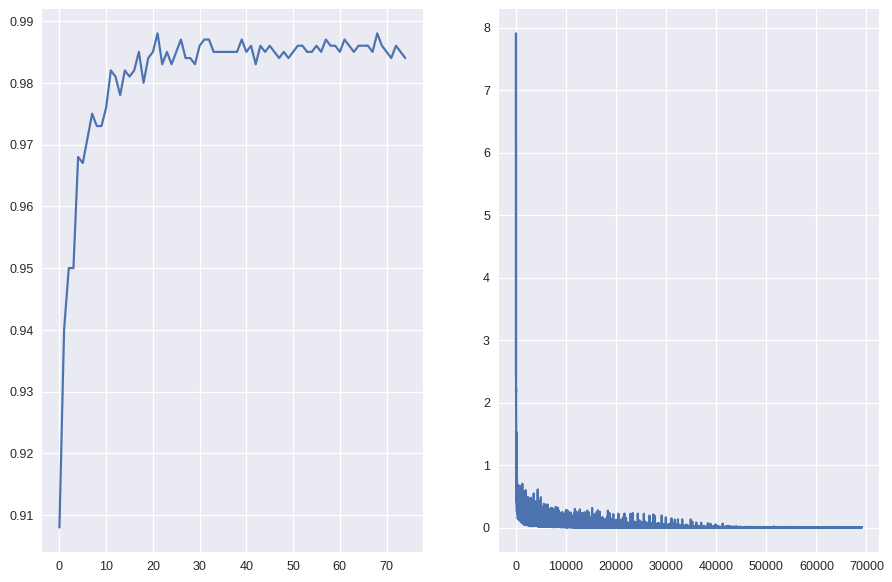

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), dpi=90,
                               facecolor='w', edgecolor='k',
                               sharey=False)
ax1.plot(perf_val_all[0])
ax2.plot([c for e, itr, c in perf_train_cost_all[0]])
plt.show()


In [42]:
num_epochs = [75, 100]
batch_size_train = [32, 64]
lr_base = [0.5]
x, y = np.meshgrid(num_epochs, batch_size_train, )
# print(x)
# print(y)
# for a,b in zip(x,y):
#     print(a,b)

def f(list_params):
    mesh = np.meshgrid(*list_params, indexing = 'ij')

    list_mesh = []
    for m in mesh: list_mesh.append(m.flatten())
    return zip(*list_mesh), mesh

list_params = [num_epochs, batch_size_train]
print(f(list_params))

([(75, 32), (75, 64), (100, 32), (100, 64)], [array([[ 75,  75],
       [100, 100]]), array([[32, 64],
       [32, 64]])])
